In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

from keras.layers import Input, Dense, BatchNormalization, Dropout
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import keras.backend as K

C:\Users\wlyip\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train = pd.read_csv('train.csv')
train_id = train.pop('Id')
# train.drop('Id', axis=1, inplace=True)

test = pd.read_csv('test.csv')
test_id = test.pop('Id')
# test.drop('Id', axis=1, inplace=True)

print('Shape of train data: {}'.format(train.shape))
print('Shape of test data: {}'.format(test.shape))
# print('')
# print('List of features:\n', list(train.columns))

Shape of train data: (1460, 80)
Shape of test data: (1459, 79)


## Delete Outliers

In [3]:
# delete outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

In [4]:
num_train = train.shape[0]
num_test = test.shape[0]
y_train = train.pop('SalePrice')
all_data = pd.concat((train, test)).reset_index(drop=True)

print('Shape of all_data: {}'.format(all_data.shape))

Shape of all_data: (2917, 79)


**Log-transformation to SalePrice**

In [5]:
y_train = np.log1p(y_train)

## Missing Values 

- **PoolQC**: NA means "No Pool"
- **MiscFeature**: NA means "no misc feature"
- **Alley**: NA means "no alley access"
- **Fence**: NA means "no fence"
- **FireplaceQu**: NA means "no fireplace"

In [6]:
all_data['PoolQC'].fillna('None', inplace=True)
all_data['MiscFeature'].fillna('None', inplace=True)
all_data['Alley'].fillna('None', inplace=True)
all_data['Fence'].fillna('None', inplace=True)
all_data['FireplaceQu'].fillna('None', inplace=True)

- **LotFrontage**: should be similar to median LotFrontage of the neighborhood

In [7]:
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median()))

- **GarageType, GarageFinish, GarageQual, GarageCond**: replace missing values with None

In [8]:
all_data['GarageType'].fillna('None', inplace=True)
all_data['GarageFinish'].fillna('None', inplace=True)
all_data['GarageQual'].fillna('None', inplace=True)
all_data['GarageCond'].fillna('None', inplace=True)

- **GarageYrBlt, GarageArea, GarageCars**: NA means no car in garage

In [9]:
all_data['GarageYrBlt'].fillna(0, inplace=True)
all_data['GarageArea'].fillna(0, inplace=True)
all_data['GarageCars'].fillna(0, inplace=True)

- **BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath, BsmtHalfBath**: NA means no basement

In [10]:
all_data['BsmtFinSF1'].fillna(0, inplace=True)
all_data['BsmtFinSF2'].fillna(0, inplace=True)
all_data['BsmtUnfSF'].fillna(0, inplace=True)
all_data['TotalBsmtSF'].fillna(0, inplace=True)
all_data['BsmtFullBath'].fillna(0, inplace=True)
all_data['BsmtHalfBath'].fillna(0, inplace=True)

- **BsmtQual, BsmtCond, BsmtExposure, BsmtFintype1, BsmtFinType2**: NA means no basement

In [11]:
all_data['BsmtQual'].fillna('None', inplace=True)
all_data['BsmtCond'].fillna('None', inplace=True)
all_data['BsmtExposure'].fillna('None', inplace=True)
all_data['BsmtFinType1'].fillna('None', inplace=True)
all_data['BsmtFinType2'].fillna('None', inplace=True)

- **MasVnrArea, MarVnrType**: NA means no masonry veneer

In [12]:
all_data['MasVnrType'].fillna(0, inplace=True)
all_data['MasVnrArea'].fillna(0, inplace=True)

- **MSZoning**: fill with the most common value

In [13]:
all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0], inplace=True)

- **Utilities**: almost all values are "AllPub", should be dropped

In [14]:
all_data.drop(['Utilities'], axis=1, inplace=True)

- **Functional**: NA means "typical"

In [15]:
all_data['Functional'].fillna('Functional', inplace=True)

- **Electrical**: fill with the most common value

In [16]:
all_data['Electrical'].fillna(all_data['Electrical'].mode()[0], inplace=True)

- **KitchenQual**: fill with the most common value

In [17]:
all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0], inplace=True)

- **Exterior1st, Exterior2nd**: fill with the most common value

In [18]:
all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0], inplace=True)
all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0], inplace=True)

- **SaleType**: fill with the most common value

In [19]:
all_data['SaleType'].fillna(all_data['SaleType'].mode()[0], inplace=True)

- **MSSubClass**: NA means "no building class"

In [20]:
all_data['MSSubClass'].fillna('None', inplace=True)

**check if any missing value**

In [21]:
all_data.isnull().sum()[all_data.isnull().sum()>0]

Series([], dtype: int64)

## Convert categorical variable into numerical variable

In [22]:
# create a list containing all numerical variables
col_num = all_data.select_dtypes(exclude='object').columns
col_num = col_num.drop(['MSSubClass', 'OverallQual', 'OverallCond', 'YrSold',
                       'MoSold', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt'])
col_num

Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

In [23]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

# ordinal variables
#Changing OverallCond into a categorical variable
# all_data['OverallCond'] = all_data['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)
all_data['YearBuilt'] = all_data['YearBuilt'].astype(str)
all_data['YearRemodAdd'] = all_data['YearRemodAdd'].astype(str)
all_data['GarageYrBlt'] = all_data['GarageYrBlt'].astype(str)

In [24]:
# convert ordinal variable into numerical variable

# Ex, Gd, TA, Fa, Po, NA
cols_ExGd = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
            'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual',
            'GarageCond', 'PoolQC']
dict_ExGd = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}
for col in cols_ExGd:
    all_data[col].replace(dict_ExGd, inplace=True)

# other ordinal variables
all_data['LotShape'].replace({'Reg': 3, 'IR1': 2, 'IR2': 1, 'IR3': 0}, inplace=True)
all_data['LandSlope'].replace({'Gtl': 2, 'Mod': 1, 'Sev': 0}, inplace=True)
all_data['BsmtExposure'].replace({'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0}, inplace=True)
all_data['CentralAir'].replace({'Y': 1, 'N': 0}, inplace=True)
all_data['Functional'].replace({'Typ': 7, 'Min1': 6, 'Min2': 5, 'Mod': 4, 
                                'Maj1': 3, 'Maj2': 2, 'Sev': 1, 'Sal': 0},
                              inplace=True)
all_data['GarageFinish'].replace({'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0}, inplace=True)

## Dealing with zeros

In [25]:
# fraction of zeros in each column
frac_zeros = (all_data==0).sum()/len(all_data)
# no. unique values in each column
n_unique = all_data.nunique()
# difference between frac. zeros and expected
xs_zeros = frac_zeros - 1/n_unique

# create dataframe containing above columns
zero_cols = pd.DataFrame({'frac_zeros': frac_zeros, 'n_unique': n_unique,
                         'xs_zeros': xs_zeros})
zero_cols = zero_cols[zero_cols.frac_zeros>0]
zero_cols.sort_values(by='xs_zeros', ascending=False, inplace=True)
display(zero_cols[(zero_cols.xs_zeros>0)])

,frac_zeros,n_unique,xs_zeros
LowQualFinSF,0.986287,36,0.958510
3SsnPorch,0.987316,31,0.955058
MiscVal,0.964690,38,0.938374
PoolArea,0.995886,13,0.918963
ScreenPorch,0.912239,121,0.903974
BsmtFinSF2,0.881042,272,0.877366
EnclosedPorch,0.842647,183,0.837182
PoolQC,0.996915,4,0.746915
BsmtHalfBath,0.940007,3,0.606674
MasVnrArea,0.603702,442,0.601440


In [26]:
# create binary variables for Pool and 3SsnPorch
all_data['HasPool'] = (all_data['PoolQC']>0).astype(int)
all_data['Has3SsnPorch'] = (all_data['3SsnPorch']>0).astype(int)
all_data.drop(['PoolQC', 'PoolArea', '3SsnPorch'], axis=1, inplace=True)

# combine HalfBath to FullBath
all_data['BsmtFullBath'] = all_data['BsmtFullBath'] + 0.5*all_data['BsmtHalfBath']
all_data['FullBath'] = all_data['FullBath'] + 0.5*all_data['HalfBath']
all_data.drop(['BsmtHalfBath', 'HalfBath'], axis=1, inplace=True)

In [27]:
# # create additional dummy variable for continuous variable
# dummy_cols = ['LowQualFinSF', 'MiscVal', '2ndFlrSF', 'ScreenPorch', 'WoodDeckSF',
#              'OpenPorchSF', 'EnclosedPorch', 'MasVnrArea', 'GarageArea', 'Fireplaces',
#              'BsmtFinSF2', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF']
# for col in dummy_cols:
#     all_data['Has'+col] = (all_data[col]>0).astype(int)

In [28]:
def minmax_scale(col):
    return (col-col.min())/(col.max()-col.min())

In [29]:
col_num = col_num.drop(['PoolArea', '3SsnPorch', 'BsmtHalfBath', 'HalfBath'])

for col in col_num:
    all_data[col] = minmax_scale(all_data[col])

**Getting dummy variables**

In [30]:
print('shape of all_data: {}'.format(all_data.shape))
display(all_data.select_dtypes(include='object').columns)

shape of all_data: (2917, 75)


Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LandContour', 'LotConfig',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'Electrical', 'Functional',
       'GarageType', 'GarageYrBlt', 'PavedDrive', 'Fence', 'MiscFeature',
       'MoSold', 'YrSold', 'SaleType', 'SaleCondition'],
      dtype='object')

In [31]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 559)


## Split train and test set

In [32]:
X_train = all_data[:num_train]
X_test = all_data[num_train:]

In [33]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [34]:
all_data.isnull().sum()[all_data.isnull().sum()>0]

Series([], dtype: int64)

## Random Forest

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

In [36]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

C:\Users\wlyip\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [37]:
prediction = model.predict(X_val)
MAE = mean_absolute_error(y_val, prediction)
print('Validation MAE:', MAE)

Validation MAE: 0.11310306747788852


In [38]:
kfold = StratifiedKFold(n_splits = 10)

In [40]:
model = RandomForestRegressor()
rf_param_grid = {"max_features": [0.2, 0.4, 0.6, 0.8, 1],
              "min_samples_split": [2, 4, 6, 8],
              "n_estimators" :[100, 150, 200]}

gsRFR = GridSearchCV(model, param_grid = rf_param_grid,
                     scoring = 'neg_mean_squared_error', verbose = 1)

gsRFR.fit(X_train, y_train)

RFR_best = gsRFR.best_estimator_

gsRFR.best_score_

C:\Users\wlyip\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  4.0min finished


-0.019018710981992534

In [41]:
prediction = RFR_best.predict(X_val)
MAE = mean_absolute_error(y_val, prediction)
print('Validation MAE:', MAE)

Validation MAE: 0.09904609589968204


In [121]:
prediction = RFR_best.predict(X_test)
prediction = np.expm1(prediction)
submission = pd.DataFrame()
submission['Id'] = test_id
submission['SalePrice'] = prediction
submission.to_csv('randomforest_best.csv', index=False)

## Linear Regression

In [42]:
from sklearn.linear_model import Ridge

In [43]:
model = Ridge()
model.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [44]:
prediction = model.predict(X_val)
MAE = mean_absolute_error(y_val, prediction)
print('Validation MAE:', MAE)

Validation MAE: 0.09768715562426745


In [45]:
model = Ridge()
ridge_param_grid = {"fit_intercept": [True, False],
              "normalize": [False],
              "copy_X": [True],
              "max_iter": [100, 300, 500, 1000],
              "solver": ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg',
                        'sag', 'saga']}

gsRidge = GridSearchCV(model, param_grid = ridge_param_grid, 
                     scoring = 'neg_mean_squared_error', verbose = 1)

gsRidge.fit(X_train, y_train)

Ridge_best = gsRidge.best_estimator_

gsRidge.best_score_

C:\Users\wlyip\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 56 candidates, totalling 168 fits


C:\Users\wlyip\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\wlyip\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\wlyip\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\wlyip\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\wlyip\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

-0.016273427053969145

In [46]:
prediction = Ridge_best.predict(X_val)
MAE = mean_absolute_error(y_val, prediction)
print('Validation MAE:', MAE)

Validation MAE: 0.09438791403782963


In [89]:
prediction = Ridge_best.predict(X_test)
prediction = np.expm1(prediction)
submission = pd.DataFrame()
submission['Id'] = test_id
submission['SalePrice'] = prediction
submission.to_csv('ridge_best.csv', index=False)

**Lasso**

In [47]:
from sklearn.linear_model import Lasso

In [48]:
model = Lasso()
model.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [49]:
prediction = model.predict(X_val)
MAE = mean_absolute_error(y_val, prediction)
print('Validation MAE:', MAE)

Validation MAE: 0.3147234720540678


In [50]:
model = Lasso()
alpha_range = np.arange(1e-4, 1e-3, 4e-5)
lasso_param_grid = {'alpha': alpha_range}

gsLasso = GridSearchCV(model, param_grid = lasso_param_grid, 
                     scoring = 'neg_mean_squared_error', verbose = 1)

gsLasso.fit(X_train, y_train)

Lasso_best = gsLasso.best_estimator_

gsLasso.best_score_

C:\Users\wlyip\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 23 candidates, totalling 69 fits


[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:    7.8s finished


-0.013645045068906599

In [51]:
prediction = Lasso_best.predict(X_val)
MAE = mean_absolute_error(y_val, prediction)
print('Validation MAE:', MAE)

Validation MAE: 0.0881820905382536


In [103]:
prediction = Lasso_best.predict(X_test)
prediction = np.expm1(prediction)
submission = pd.DataFrame()
submission['Id'] = test_id
submission['SalePrice'] = prediction
submission.to_csv('lasso_best.csv', index=False)

**ElasticNet**

In [52]:
from sklearn.linear_model import ElasticNet

In [53]:
model = ElasticNet()
model.fit(X_train, y_train)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [54]:
prediction = model.predict(X_val)
MAE = mean_absolute_error(y_val, prediction)
print('Validation MAE:', MAE)

Validation MAE: 0.3147234720540678


In [55]:
model = ElasticNet()

elastic_param_grid = {'alpha': np.arange(1e-4, 1e-3, 1e-4),
                   'l1_ratio': np.arange(0.1, 1.0, 0.1),
                   'max_iter': [100000]}

gsElastic = GridSearchCV(model, param_grid = elastic_param_grid, 
                     scoring = 'neg_mean_squared_error', verbose = 1)

gsElastic.fit(X_train, y_train)

Elastic_best = gsElastic.best_estimator_

gsElastic.best_score_

C:\Users\wlyip\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=1)]: Done 243 out of 243 | elapsed:  1.1min finished


-0.013645806885684685

In [56]:
prediction = Elastic_best.predict(X_val)
MAE = mean_absolute_error(y_val, prediction)
print('Validation MAE:', MAE)

Validation MAE: 0.08829295735229059


In [106]:
prediction = Elastic_best.predict(X_test)
prediction = np.expm1(prediction)
submission = pd.DataFrame()
submission['Id'] = test_id
submission['SalePrice'] = prediction
submission.to_csv('elastic_best.csv', index=False)

## SVM

**Linear**

In [57]:
from sklearn.svm import LinearSVR

In [58]:
model = LinearSVR()
model.fit(X_train, y_train)

C:\Users\wlyip\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0)

In [59]:
prediction = model.predict(X_val)
MAE = mean_absolute_error(y_val, prediction)
print('Validation MAE:', MAE)

Validation MAE: 0.14795620857724562


In [60]:
model = LinearSVR()

linearSVR_param_grid = {'C': np.arange(0.1, 1.0, 0.1),
                   'max_iter': [100000]}

gslinearSVR = GridSearchCV(model, param_grid = linearSVR_param_grid, 
                     scoring = 'neg_mean_squared_error', verbose = 1)

gslinearSVR.fit(X_train, y_train)

LinearSVR_best = gslinearSVR.best_estimator_

gslinearSVR.best_score_

C:\Users\wlyip\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 9 candidates, totalling 27 fits


C:\Users\wlyip\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  2.4min finished


-0.025992567378039982

In [61]:
prediction = LinearSVR_best.predict(X_val)
MAE = mean_absolute_error(y_val, prediction)
print('Validation MAE:', MAE)

Validation MAE: 0.10607930905762229


In [112]:
prediction = LinearSVR_best.predict(X_test)
prediction = np.expm1(prediction)
submission = pd.DataFrame()
submission['Id'] = test_id
submission['SalePrice'] = prediction
submission.to_csv('linearSVR_best.csv', index=False)

**Non-Linear**

In [62]:
from sklearn.svm import SVR

In [63]:
model = SVR()
model.fit(X_train, y_train)

C:\Users\wlyip\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [64]:
prediction = model.predict(X_val)
MAE = mean_absolute_error(y_val, prediction)
print('Validation MAE:', MAE)

Validation MAE: 0.11808268663667205


In [65]:
model = SVR()

SVR_param_grid = {'C': np.arange(1, 21, 2),
                       'kernel': ['poly', 'rbf', 'sigmoid'],
                       'gamma': ['auto']}

gsSVR = GridSearchCV(model, param_grid = SVR_param_grid, 
                     scoring = 'neg_mean_squared_error', verbose = 1)

gsSVR.fit(X_train, y_train)

SVR_best = gsSVR.best_estimator_

gsSVR.best_score_

Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\wlyip\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.0min finished


-0.01703471725538293

In [66]:
prediction = LinearSVR_best.predict(X_val)
MAE = mean_absolute_error(y_val, prediction)
print('Validation MAE:', MAE)

Validation MAE: 0.10607930905762229


In [118]:
prediction = SVR_best.predict(X_test)
prediction = np.expm1(prediction)
submission = pd.DataFrame()
submission['Id'] = test_id
submission['SalePrice'] = prediction
submission.to_csv('SVR_best.csv', index=False)

## Gradient Boosting

In [67]:
from sklearn.ensemble import GradientBoostingRegressor

In [68]:
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [69]:
prediction = model.predict(X_val)
MAE = mean_absolute_error(y_val, prediction)
print('Validation MAE:', MAE)

Validation MAE: 0.09793069961099322


In [70]:
model = GradientBoostingRegressor()

GBR_param_grid = {'n_estimators': [150, 250, 350],
                       'max_depth': [1, 2, 3],
                       'min_samples_split': [5, 6, 7]}

gsGBR = GridSearchCV(model, param_grid = GBR_param_grid, 
                     scoring = 'neg_mean_squared_error', verbose = 1)

gsGBR.fit(X_train, y_train)

GBR_best = gsGBR.best_estimator_

gsGBR.best_score_

Fitting 3 folds for each of 27 candidates, totalling 81 fits


C:\Users\wlyip\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:  1.6min finished


-0.01601828518560364

In [71]:
prediction = GBR_best.predict(X_val)
MAE = mean_absolute_error(y_val, prediction)
print('Validation MAE:', MAE)

Validation MAE: 0.09684031945315108


In [127]:
prediction = GBR_best.predict(X_test)
prediction = np.expm1(prediction)
submission = pd.DataFrame()
submission['Id'] = test_id
submission['SalePrice'] = prediction
submission.to_csv('GBR_best.csv', index=False)

**XGBoost**

In [72]:
from xgboost import XGBRegressor

In [73]:
model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [74]:
model = XGBRegressor()

XGB_param_grid = {'n_estimators': [100, 200, 300, 400, 500],
                   'max_depth': [1, 2, 3]}

gsXGB = GridSearchCV(model, param_grid = XGB_param_grid, 
                     scoring = 'neg_mean_squared_error', verbose = 1)

gsXGB.fit(X_train, y_train)

XGB_best = gsXGB.best_estimator_

gsXGB.best_score_

C:\Users\wlyip\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  1.2min finished


-0.01520978589282166

In [75]:
prediction = XGB_best.predict(X_val)
MAE = mean_absolute_error(y_val, prediction)
print('Validation MAE:', MAE)

Validation MAE: 0.0932823356233039


In [132]:
prediction = XGB_best.predict(X_test)
prediction = np.expm1(prediction)
submission = pd.DataFrame()
submission['Id'] = test_id
submission['SalePrice'] = prediction
submission.to_csv('XGB_best.csv', index=False)

## Model Review

**ElasticNet**

---------------------------------------
425 zero coefficients
134 non-zero coefficients
---------------------------------------
Intercept:  10.422956983719992
---------------------------------------
Top 20 contributers to increased price:
---------------------------------------
GrLivArea               1.115956
TotalBsmtSF             0.292262
BsmtFinSF1              0.190665
FullBath                0.167901
GarageCars              0.133748
GarageArea              0.112906
LotArea                 0.107753
Neighborhood_Crawfor    0.098022
Neighborhood_StoneBr    0.089175
WoodDeckSF              0.086748
ScreenPorch             0.074713
BsmtFullBath            0.065927
OverallQual             0.063245
CentralAir              0.061866
Neighborhood_NridgHt    0.060825
BsmtExposure_4          0.056656
Functional_7            0.055747
Neighborhood_BrkSide    0.045914
Heating_GasW            0.045393
Neighborhood_ClearCr    0.043383
dtype: float64
---------------------------------------
Top 10

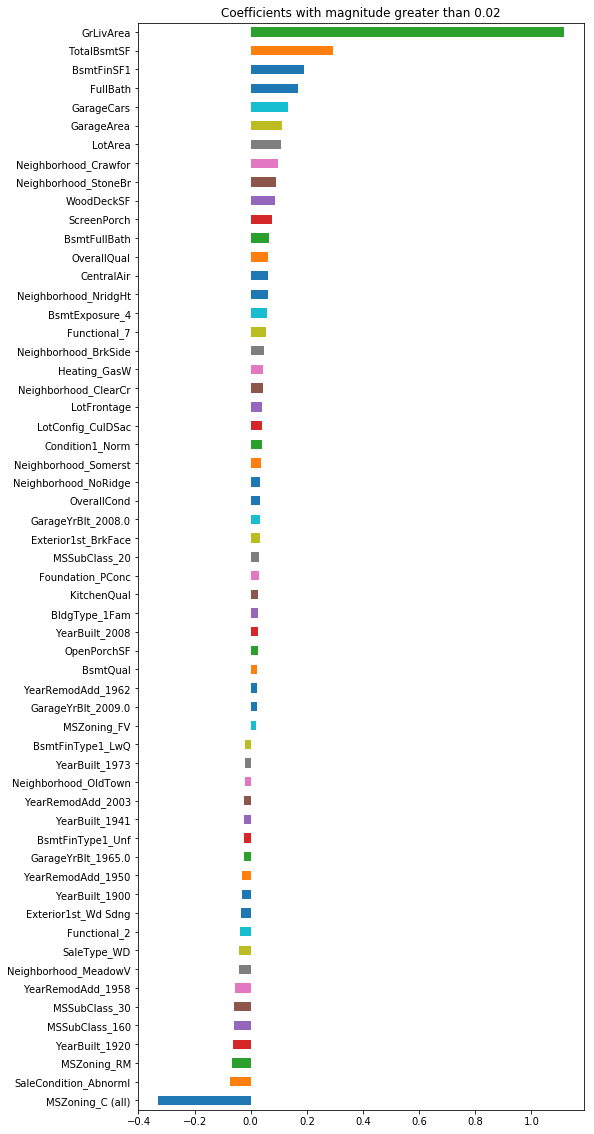

In [133]:
en_coefs = pd.Series(Elastic_best.coef_, index=X_train.columns)

plt.figure(figsize=(8, 20))
en_coefs[en_coefs.abs()>0.02].sort_values().plot.barh()
plt.title('Coefficients with magnitude greater than 0.02')

print('---------------------------------------')
print(sum(en_coefs==0),'zero coefficients')
print(sum(en_coefs!=0),'non-zero coefficients')
print('---------------------------------------')
print('Intercept: ', Elastic_best.intercept_)
print('---------------------------------------')
print('Top 20 contributers to increased price:')
print('---------------------------------------')
print(en_coefs.sort_values(ascending=False).head(20))
print('---------------------------------------')
print('Top 10 contributers to decreased price:')
print('---------------------------------------')
print(en_coefs.sort_values(ascending=True).head(10))
print('---------------------------------------')
print('Zero coefficients:')
print('---------------------------------------')
print(en_coefs[en_coefs==0].index.sort_values().tolist())

**Lasso**

---------------------------------------
440 zero coefficients
119 non-zero coefficients
---------------------------------------
Intercept:  10.42982190701777
---------------------------------------
Top 20 contributers to increased price:
---------------------------------------
GrLivArea               1.155004
TotalBsmtSF             0.277653
BsmtFinSF1              0.188105
FullBath                0.152974
GarageCars              0.134215
GarageArea              0.109031
Neighborhood_Crawfor    0.093533
Neighborhood_StoneBr    0.085204
LotArea                 0.079830
WoodDeckSF              0.076821
ScreenPorch             0.067654
BsmtFullBath            0.065221
OverallQual             0.063448
Neighborhood_NridgHt    0.060628
CentralAir              0.060050
BsmtExposure_4          0.058277
Functional_7            0.055496
Neighborhood_BrkSide    0.044052
Heating_GasW            0.043335
Neighborhood_ClearCr    0.042063
dtype: float64
---------------------------------------
Top 10 

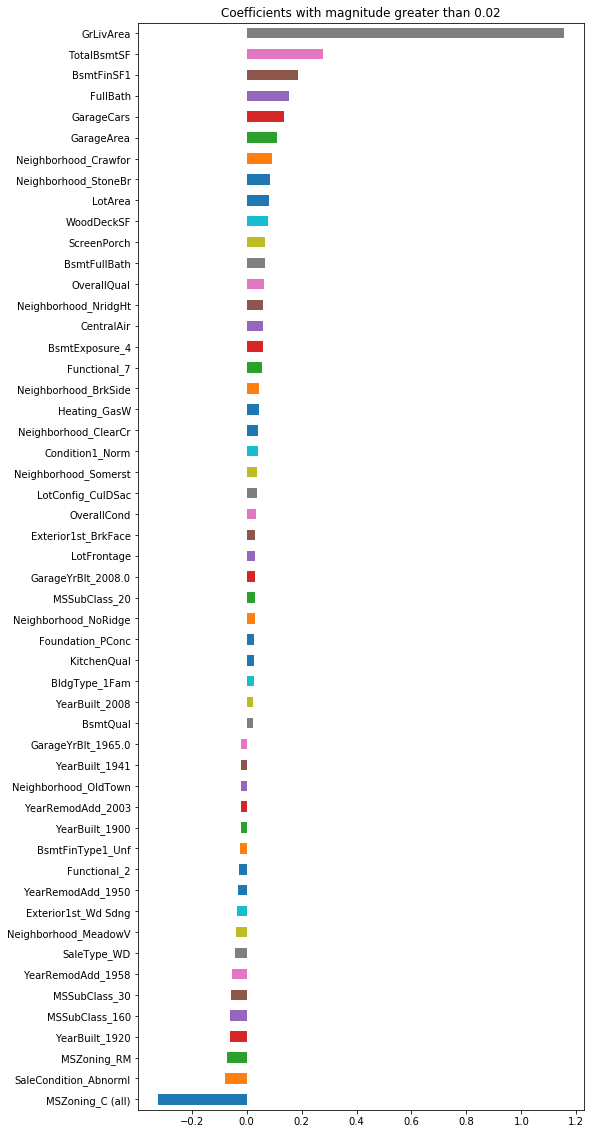

In [134]:
lasso_coefs = pd.Series(Lasso_best.coef_, index=X_train.columns)

plt.figure(figsize=(8, 20))
lasso_coefs[lasso_coefs.abs()>0.02].sort_values().plot.barh()
plt.title('Coefficients with magnitude greater than 0.02')

print('---------------------------------------')
print(sum(lasso_coefs==0),'zero coefficients')
print(sum(lasso_coefs!=0),'non-zero coefficients')
print('---------------------------------------')
print('Intercept: ', Lasso_best.intercept_)
print('---------------------------------------')
print('Top 20 contributers to increased price:')
print('---------------------------------------')
print(lasso_coefs.sort_values(ascending=False).head(20))
print('---------------------------------------')
print('Top 10 contributers to decreased price:')
print('---------------------------------------')
print(lasso_coefs.sort_values(ascending=True).head(10))
print('---------------------------------------')
print('Zero coefficients:')
print('---------------------------------------')
print(lasso_coefs[lasso_coefs==0].index.sort_values().tolist())

## Train model with only useful features

In [137]:
from sklearn.preprocessing import PolynomialFeatures

In [139]:
select_cols = [col for col in X_train.columns if X_train[col].nunique()>2 and lasso_coefs[col]!=0]
X_train = X_train[select_cols]

# add interaction terms
poly = PolynomialFeatures(interaction_only=True)
X_poly = poly.fit_transform(X_train, y_train)
X_poly = pd.DataFrame(X_poly, index=y_train.index)

# save info on which features contribute to each term in X_poly
powers = pd.DataFrame(poly.powers_, columns=X_train.columns)

s = np.where(powers>0, pd.Series(X_train.columns)+', ', '')
poly_terms = pd.Series([''.join(x).strip() for x in s])

# fit a new model with the interaction terms
alph_range = np.arange(5e-5,2e-4,2e-5)
param_grid = {'alpha': np.arange(1e-4,1e-3,1e-4),
              'max_iter':[100000]}

model = Lasso()
gsLasso = GridSearchCV(model, param_grid = param_grid, 
                     scoring = 'neg_mean_squared_error', verbose = 1)

gsLasso.fit(X_poly, y_train)

Lasso_refit = gsLasso.best_estimator_

# gsLasso.best_score_

poly_coefs = pd.Series(Lasso_refit.coef_)

print('------------------------')
print(sum(poly_coefs==0),'zero coefficients')
print(sum(poly_coefs!=0),'non-zero coefficients')
print(len(poly_coefs[(powers.sum(axis=1)==2) & (poly_coefs>0)]),'non-zero interaction terms.')
print('------------------------')
print('Features with largest coefficients:')
print('------------------------')
print(poly_terms[poly_coefs.abs().sort_values(ascending=False).index[:30]])
print('------------------------')

C:\Users\wlyip\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  2.0min finished


------------------------
207 zero coefficients
70 non-zero coefficients
39 non-zero interaction terms.
------------------------
Features with largest coefficients:
------------------------
71          LotShape, BsmtFinSF1,
76            LotShape, FullBath,
4                    OverallQual,
5                    OverallCond,
272      GarageCond, OpenPorchSF,
111       OverallCond, GrLivArea,
142        BsmtQual, TotalBsmtSF,
109     OverallCond, TotalBsmtSF,
25         LotFrontage, LotShape,
47          LotArea, OverallQual,
15                   FireplaceQu,
186         HeatingQC, GrLivArea,
213    BsmtFullBath, FireplaceQu,
201       GrLivArea, KitchenQual,
234      KitchenQual, GarageCars,
137        ExterQual, GarageCond,
238      KitchenQual, WoodDeckSF,
146           BsmtQual, FullBath,
122     OverallCond, OpenPorchSF,
141         BsmtQual, BsmtFinSF1,
10                     HeatingQC,
145       BsmtQual, BsmtFullBath,
242      FireplaceQu, GarageCars,
143          BsmtQual, Heatin

In [76]:
from sklearn.model_selection import learning_curve

In [91]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                       train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv = cv, train_sizes = train_sizes,
        scoring='neg_mean_squared_error')
    
    train_scores = np.sqrt(-train_scores)
    test_scores = np.sqrt(-test_scores)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha = 0.1,
                     color = "r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha = 0.1, color = "g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color = "r",
             label = "Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color = "g",
             label = "Cross-validation score")

    plt.legend(loc = "best")
    return plt

C:\Users\wlyip\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\wlyip\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\wlyip\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\wlyip\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\wlyip\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

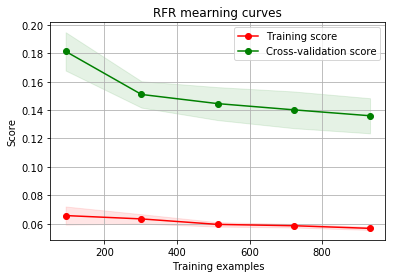

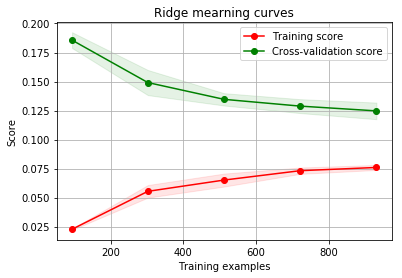

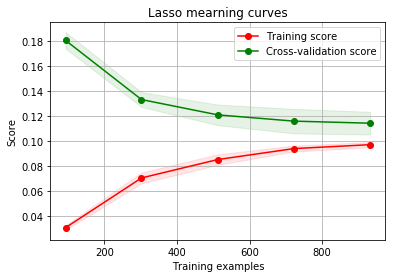

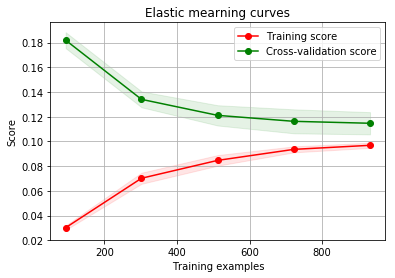

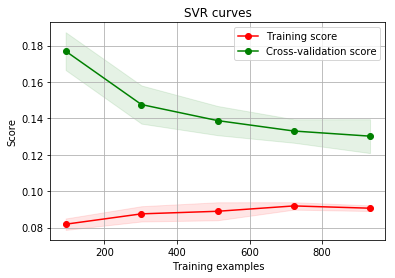

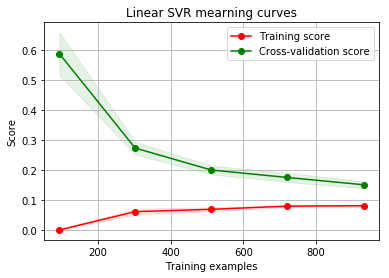

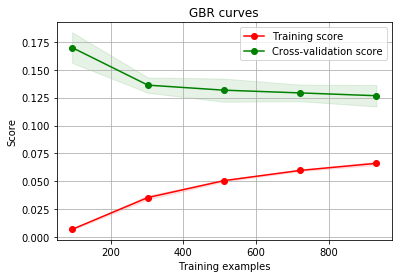

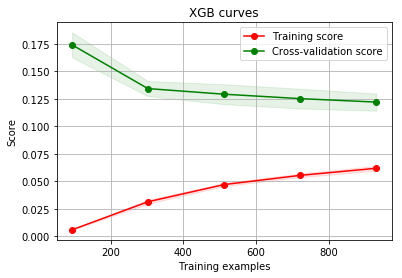

In [92]:
g = plot_learning_curve(RFR_best,"RFR mearning curves", X_train, y_train, cv=5)
g = plot_learning_curve(Ridge_best,"Ridge mearning curves", X_train, y_train, cv=5)
g = plot_learning_curve(Lasso_best,"Lasso mearning curves", X_train, y_train, cv=5)
g = plot_learning_curve(Elastic_best,"Elastic mearning curves", X_train, y_train, cv=5)
g = plot_learning_curve(SVR_best,"SVR curves", X_train, y_train, cv=5)
g = plot_learning_curve(LinearSVR_best,"Linear SVR mearning curves", X_train, y_train, cv=5)
g = plot_learning_curve(GBR_best,"GBR curves", X_train, y_train, cv=5)
g = plot_learning_curve(XGB_best,"XGB curves", X_train, y_train, cv=5)

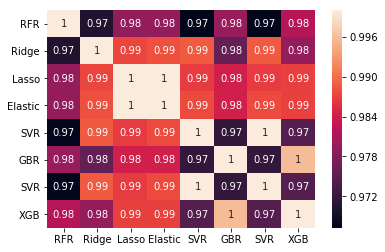

In [83]:
val_RFR = pd.Series(RFR_best.predict(X_val), name="RFR")
val_Ridge = pd.Series(Ridge_best.predict(X_val), name="Ridge")
val_Lasso = pd.Series(Lasso_best.predict(X_val), name="Lasso")
val_Elastic = pd.Series(Elastic_best.predict(X_val), name="Elastic")
val_SVR = pd.Series(SVR_best.predict(X_val), name="SVR")
val_GBR = pd.Series(GBR_best.predict(X_val), name="GBR")
val_SVR = pd.Series(SVR_best.predict(X_val), name="SVR")
val_XGB = pd.Series(XGB_best.predict(X_val), name="XGB")


# Concatenate all classifier results
ensemble_results = pd.concat([val_RFR, val_Ridge,
                              val_Lasso, val_Elastic, 
                              val_SVR, val_GBR, val_SVR, val_XGB],
                              axis = 1)


g = sns.heatmap(ensemble_results.corr(), annot=True)

## Ensemble Model

In [93]:
# Lasso and ElasticNet perform the best
Lasso_pred = Lasso_best.predict(X_test)
Lasso_pred = np.expm1(Lasso_pred)

Elastic_pred = Elastic_best.predict(X_test)
Elastic_pred = np.expm1(Elastic_pred)

prediction = 0.5*Lasso_pred + 0.5*Elastic_pred
submission = pd.DataFrame()
submission['Id'] = test_id
submission['SalePrice'] = prediction

submission.to_csv('ensemble.csv', index=False)

**ensemble all model**

In [105]:
# train_RFR = pd.Series(RFR_best.predict(X_train), name="RFR")
train_Ridge = pd.Series(Ridge_best.predict(X_train), name="Ridge")
train_Lasso = pd.Series(Lasso_best.predict(X_train), name="Lasso")
train_Elastic = pd.Series(Elastic_best.predict(X_train), name="Elastic")
# train_SVR = pd.Series(SVR_best.predict(X_train), name="SVR")
train_GBR = pd.Series(GBR_best.predict(X_train), name="GBR")
train_XGB = pd.Series(XGB_best.predict(X_train), name="XGB")

model_train = pd.DataFrame({'Ridge': train_Ridge, 'Lasso': train_Lasso,
                           'Elastic': train_Elastic, 
                           'GBR': train_GBR, 'XGB': train_XGB})
# model_train = pd.DataFrame({'RFR': train_RFR, 'Ridge': train_Ridge, 'Lasso': train_Lasso,
#                            'Elastic': train_Elastic, 'SVR': train_SVR,
#                            'GBR': train_GBR, 'SVR': train_SVR, 'XGB': train_XGB})

model_train.head(5)

,Ridge,Lasso,Elastic,GBR,XGB
0,12.226846,12.196965,12.205722,12.153507,12.136761
1,11.783586,11.735802,11.739609,11.776104,11.764278
2,12.326235,12.302696,12.306299,12.349777,12.345193
3,11.962810,11.980423,11.989932,11.882434,11.886724
4,11.440523,11.501384,11.504545,11.364465,11.344524


In [106]:
# val_RFR = pd.Series(RFR_best.predict(X_val), name="RFR")
val_Ridge = pd.Series(Ridge_best.predict(X_val), name="Ridge")
val_Lasso = pd.Series(Lasso_best.predict(X_val), name="Lasso")
val_Elastic = pd.Series(Elastic_best.predict(X_val), name="Elastic")
# val_SVR = pd.Series(SVR_best.predict(X_val), name="SVR")
val_GBR = pd.Series(GBR_best.predict(X_val), name="GBR")
val_XGB = pd.Series(XGB_best.predict(X_val), name="XGB")

model_val = pd.DataFrame({'Ridge': val_Ridge, 'Lasso': val_Lasso,
                           'Elastic': val_Elastic,
                           'GBR': val_GBR, 'XGB': val_XGB})
# model_val = pd.DataFrame({'RFR': val_RFR, 'Ridge': val_Ridge, 'Lasso': val_Lasso,
#                            'Elastic': val_Elastic, 'SVR': val_SVR,
#                            'GBR': val_GBR, 'SVR': val_SVR, 'XGB': val_XGB})

model_val.head(5)

,Ridge,Lasso,Elastic,GBR,XGB
0,11.789417,11.852826,11.850235,11.826740,11.794394
1,11.725277,11.772895,11.769952,11.736097,11.765250
2,11.520451,11.499648,11.501782,11.481822,11.459526
3,12.208330,12.192422,12.199270,12.151554,12.162286
4,12.066033,12.103301,12.102103,12.137407,12.188095


In [98]:
from sklearn.linear_model import LinearRegression

In [107]:
meta_model = LinearRegression()
meta_model.fit(model_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [108]:
prediction = XGB_best.predict(X_val)
MAE = mean_absolute_error(y_val, prediction)
print('Validation MAE:', MAE)

Validation MAE: 0.0932823356233039


In [109]:
# test_RFR = pd.Series(RFR_best.predict(X_test), name="RFR")
test_Ridge = pd.Series(Ridge_best.predict(X_test), name="Ridge")
test_Lasso = pd.Series(Lasso_best.predict(X_test), name="Lasso")
test_Elastic = pd.Series(Elastic_best.predict(X_test), name="Elastic")
# test_SVR = pd.Series(SVR_best.predict(X_test), name="SVR")
test_GBR = pd.Series(GBR_best.predict(X_test), name="GBR")
test_XGB = pd.Series(XGB_best.predict(X_test), name="XGB")

model_test = pd.DataFrame({'Ridge': test_Ridge, 'Lasso': test_Lasso,
                           'Elastic': test_Elastic,
                           'GBR': test_GBR, 'XGB': test_XGB})
# model_test = pd.DataFrame({'RFR': test_RFR, 'Ridge': test_Ridge, 'Lasso': test_Lasso,
#                            'Elastic': test_Elastic, 'SVR': test_SVR,
#                            'GBR': test_GBR, 'SVR': test_SVR, 'XGB': test_XGB})




prediction = meta_model.predict(model_test)
prediction = np.expm1(prediction)
submission = pd.DataFrame()
submission['Id'] = test_id
submission['SalePrice'] = prediction

submission.to_csv('meta_model.csv', index=False)